In [1]:
# Importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Importing the proteins data
prm = []
prmd = []

f = open("../../../../../../Data/Proteins/DENV1/PrM/DENV1_Premembrane.txt", "r")
for x in f:   
    if "DSS" in x:
        prmd.append(1)
    elif "DHF" in x:
        prmd.append(1)
    elif x[0] == ">":
        prmd.append(0)
    else:
        x = x.replace("\n", "")
        prm.append(x)
        
# Converting the array into DataFrames
prm = pd.DataFrame(prm)

# Attaching the "Disease" label column to the input
prm["Disease"] = prmd

# Renaming the columns
prm = prm.rename(index=str, columns={0: "Sequence", "Disease": "Disease"})

# clearing the memory
del prmd

In [3]:
print("The combined shape of the given data is:", str(prm.shape))
print("The length of the combined data is:", str(len(prm.index)))
print("Does the combined data have any null value? ->", prm.isnull().values.any())

prm = prm.dropna(how = 'any',axis = 0) 

# Shuffling the data and then taking a peek
prm = prm.sample(frac = 1)

The combined shape of the given data is: (999, 2)
The length of the combined data is: 999
Does the combined data have any null value? -> False


In [4]:
# Function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size = 6):
    return [sequence[x:x + size].lower() for x in range(len(sequence) - size + 1)]

prm['words'] = prm.apply(lambda x: getKmers(x['Sequence']), axis = 1)
prm = prm.drop('Sequence', axis=1)

prm_texts = list(prm['words'])
for item in range(len(prm_texts)):
    prm_texts[item] = ' '.join(prm_texts[item])

The shape of y is: (999,)


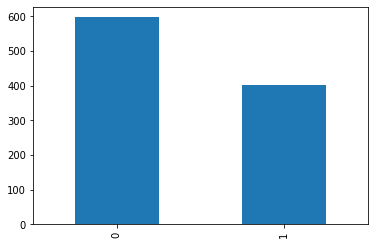

In [5]:
# Creating y and printing the shape of it
y = prm.iloc[:, 0].values
print("The shape of y is:", y.shape)

prm["Disease"].value_counts().sort_index().plot.bar()

# clearing the memory
del prm

In [6]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range = (4,4))
x = cv.fit_transform(prm_texts)

# clearing the memory
del prm_texts

In [7]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42, stratify=y)

# Printing the shapes of the train and test matrices
print("The shape of x_train is:", X_train.shape)
print("The shape of y_train is:", y_train.shape)
print("The shape of x_test is:", X_test.shape)
print("The shape of y_test is:", y_test.shape)

# clearing the memory
del x
del y

The shape of x_train is: (799, 731)
The shape of y_train is: (799,)
The shape of x_test is: (200, 731)
The shape of y_test is: (200,)


## Keras

In [8]:
# Importing the Keras libraries
from keras.models import Sequential
from keras.layers import Dense

# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=731, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=150, batch_size=10)

Using TensorFlow backend.
W0323 17:32:38.399145 140665686423360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0323 17:32:38.418941 140665686423360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0323 17:32:38.421233 140665686423360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0323 17:32:38.473440 140665686423360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0323 17:32:38.493726 14066568

Epoch 1/150
799/799 [==============================] - 0s 547us/step - loss: 0.6664 - acc: 0.5882
Epoch 2/150
799/799 [==============================] - 0s 176us/step - loss: 0.6371 - acc: 0.5945
Epoch 3/150
799/799 [==============================] - 0s 279us/step - loss: 0.6161 - acc: 0.5945
Epoch 4/150
799/799 [==============================] - 0s 386us/step - loss: 0.6124 - acc: 0.5857
Epoch 5/150
799/799 [==============================] - 0s 419us/step - loss: 0.6083 - acc: 0.6033
Epoch 6/150
799/799 [==============================] - 0s 166us/step - loss: 0.6118 - acc: 0.5920
Epoch 7/150
799/799 [==============================] - 0s 165us/step - loss: 0.6033 - acc: 0.5932
Epoch 8/150
799/799 [==============================] - 0s 169us/step - loss: 0.6041 - acc: 0.5945
Epoch 9/150
799/799 [==============================] - 0s 183us/step - loss: 0.5995 - acc: 0.5920
Epoch 10/150
799/799 [==============================] - 0s 147us/step - loss: 0.6026 - acc: 0.5932
Epoch 11/150
799/79

799/799 [==============================] - 0s 308us/step - loss: 0.5663 - acc: 0.6295
Epoch 84/150
799/799 [==============================] - 0s 313us/step - loss: 0.5657 - acc: 0.6283
Epoch 85/150
799/799 [==============================] - 0s 310us/step - loss: 0.5663 - acc: 0.6195
Epoch 86/150
799/799 [==============================] - 0s 324us/step - loss: 0.5658 - acc: 0.6070
Epoch 87/150
799/799 [==============================] - 0s 320us/step - loss: 0.5656 - acc: 0.6145
Epoch 88/150
799/799 [==============================] - 0s 337us/step - loss: 0.5662 - acc: 0.6295
Epoch 89/150
799/799 [==============================] - 0s 295us/step - loss: 0.5672 - acc: 0.6108
Epoch 90/150
799/799 [==============================] - 0s 291us/step - loss: 0.5697 - acc: 0.6283
Epoch 91/150
799/799 [==============================] - 0s 282us/step - loss: 0.5656 - acc: 0.6095
Epoch 92/150
799/799 [==============================] - 0s 284us/step - loss: 0.5645 - acc: 0.6158
Epoch 93/150
799/799 [=

In [9]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

# clearing the memory
del accuracy
del model
del X_train
del X_test
del y_test
del y_train

200/200 [==============================] - 0s 466us/step
Accuracy: 61.50
